In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime, timedelta
from pathlib import Path
from skimage import io
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras import models, layers
from keras import losses, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as K
from keras.utils import multi_gpu_model

warnings.filterwarnings('ignore')

data_folder = Path('/home/yuyuliao/ninja_project/data/airbus/')

os.listdir(str(data_folder))

Using TensorFlow backend.


_pywrap_tensorflow_internal /usr/local/lib/python3.5/dist-packages/tensorflow/python/_pywrap_tensorflow_internal.so


['train_ship_segmentations_v2.csv',
 'sample_submission_v2.csv',
 'test_v2.zip',
 'train',
 'train_v2.zip',
 'train_ship_segmentations_v2.csv.zip',
 'test']

# Load image data

In [2]:
masks = pd.read_csv(str(data_folder / 'train_ship_segmentations_v2.csv'))
train_path = data_folder / 'train'
valid_path = data_folder / 'test'
test_path = data_folder / 'test'
train_images_list = os.listdir(str(train_path))
test_images_list = os.listdir(str(test_path))

# Remove Bug image
Image data cannot be converted to float

In [3]:
masks = masks[masks['ImageId'] != '6384c3e78.jpg']

# HyperParameters setting

In [4]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 10
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'DECONV'
# Downsampling inside the network
NET_SCALING = None

# Downsampling in preprocessing
IMG_SCALING = (1, 1)

# Number of validation images to use
VALID_IMG_COUNT = 400

# Maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

# Split into training and validation groups

In [5]:
masks['ships'] = masks['EncodedPixels'].map(lambda row: 1 if isinstance(row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x > 0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda img_id: os.stat(str(train_path / img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 10 ] # keep only greater 50 kb files


In [6]:
masks.drop(['ships'], axis=1, inplace=True)
train_ids, valid_ids = train_test_split(unique_img_ids, 
                                        test_size=0.2, 
                                        stratify=unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print('Train images:{}'.format(train_df.shape[0]))
print('Valid images:{}'.format(valid_df.shape[0]))

Train images:185373
Valid images:46338


# Undersample Empty Images
Here we undersample the empty images to get a better balanced group with more ships to try and segment

In [7]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x + 1) // 2).clip(0, 7)

def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0] == 0:
        return in_df.sample(base_rep_val // 3)
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0] < base_rep_val))

balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)

# Run-length Encode and Decode alogrithm

In [8]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_deconde(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x , dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def multi_rle_encode(img):
    # labels 兩個像素點如果相鄰且同值 ，則為 1 or 0；不同則反之。用來進行標記
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels > 0])]

def masks_as_image(in_mask_list):
    all_masks = np.zeros((768, 768), dtype=np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_deconde(mask)
    return np.expand_dims(all_masks, -1) # 在最後面延伸一個維度

## Decode all the RLEs into images

In [9]:
def make_image_gen(in_df, batch_size=BATCH_SIZE):
    all_batchs = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batchs)
        for c_img_id, c_masks in all_batchs:
            rgb_path = str(train_path / c_img_id)
            c_img = io.imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values) 
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb) >= batch_size:
                yield np.stack(out_rgb, 0) / 255.0, np.stack(out_mask, 0)
                out_rgb, out_mask = [], []

In [10]:
train_gen = make_image_gen(balanced_train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1


# Make the validation Set

In [11]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(400, 768, 768, 3) (400, 768, 768, 1)


# Data Augment

In [12]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(
    featurewise_center=False,
    samplewise_center=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    data_format='channels_last'
    )

# brightness can be problematic since it seems to change 
# the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]

image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
    
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed=202109):
    for in_x, in_y in in_gen:
        g_x = image_gen.flow(255 * in_x, 
                             batch_size=in_x.shape[0],
                             seed=seed,
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size=in_y.shape[0],
                             seed=seed,
                             shuffle=True)
        yield next(g_x) / 255.0, next(g_y)

In [13]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

x (4, 768, 768, 3) float32 0.0 1.0
y (4, 768, 768, 1) float32 0.0 1.0


In [14]:
import gc
gc.collect()

19

# Build Model

In [15]:
from keras.layers import GaussianNoise, BatchNormalization
from keras.layers import Cropping2D, ZeroPadding2D, UpSampling2D

def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)   
    
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
p1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
p2 = layers.MaxPooling2D((2, 2))(c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
p3 = layers.MaxPooling2D((2, 2))(c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
# c4 = Dropout(0.2)(c4)
p4 = layers.MaxPooling2D((2, 2))(c4)

c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
# c5 = Dropout(0.3)(c5)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = layers.concatenate([u9, c1])
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)

if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 768, 768, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 768, 768, 3)  12          gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 768, 8)  224         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [16]:
#from keras.utils import plot_model
#plot_model(seg_model, to_file='u_net_model.png')

# Loss function

In [17]:
def dic_coef(y_true, y_pred, smooth=1.0):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean( (2.0 * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return 1e-3 * losses.binary_crossentropy(in_gt, in_pred) - dic_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true) * K.flatten(K.round(y_pred))) / (K.sum(y_true) + K.epsilon())


In [18]:
# Intersection over Union for Objects
def IoU(y_true, y_pred, tresh=1e-10):
    Intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    Union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - Intersection
    return K.mean( (Intersection + tresh) / (Union + tresh), axis=0)
# Intersection over Union for Background

def back_IoU(y_true, y_pred):
    return IoU(1-y_true, 1-y_pred)

# Loss function
def IoU_loss(in_gt, in_pred):
    #return 2 - back_IoU(in_gt, in_pred) - IoU(in_gt, in_pred)
    return 1 - IoU(in_gt, in_pred)

# Compile Model

In [19]:
isMultiGPU = 1
if isMultiGPU:
    parallel_model = multi_gpu_model(seg_model, 2)
    parallel_model.compile(optimizer=optimizers.Adam(1e-4, decay=1e-6), 
                           loss=dic_coef,
                           metrics=[dic_coef, 'binary_accuracy', true_positive_rate])
else:
    seg_model.compile(optimizer=optimizers.Adam(1e-4, decay=1e-6), 
                      loss=dic_coef,
                      metrics=[dic_coef, 'binary_accuracy', true_positive_rate])

## Early Stoppoing, checkpint and callbacks

In [20]:
weight_path = "{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max',
                             save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.96, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001,
                              mode='max', 
                              cooldown=2, 
                              min_lr=0.0001)

early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='max', 
                               patience=15)

callbacks_list = [checkpoint, early_stopping, reduce_lr]


# Run model

In [ ]:
%%time
import multiprocessing
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0] // BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))

if isMultiGPU:
    loss_history = [parallel_model.fit_generator(aug_gen, 
                                                 steps_per_epoch=step_count,
                                                 epochs=NB_EPOCHS,
                                                 validation_data=(valid_x, valid_y),
                                                 callbacks=callbacks_list,
                                                 use_multiprocessing=False,
                                                 workers=2)]    
else:
    loss_history = [seg_model.fit_generator(aug_gen, 
                                            steps_per_epoch=step_count,
                                            epochs=NB_EPOCHS,
                                            validation_data=(valid_x, valid_y),
                                            callbacks=callbacks_list,
                                            use_multiprocessing=False,
                                            workers=1)]

# Show result

KeyError: 'dic_coef'

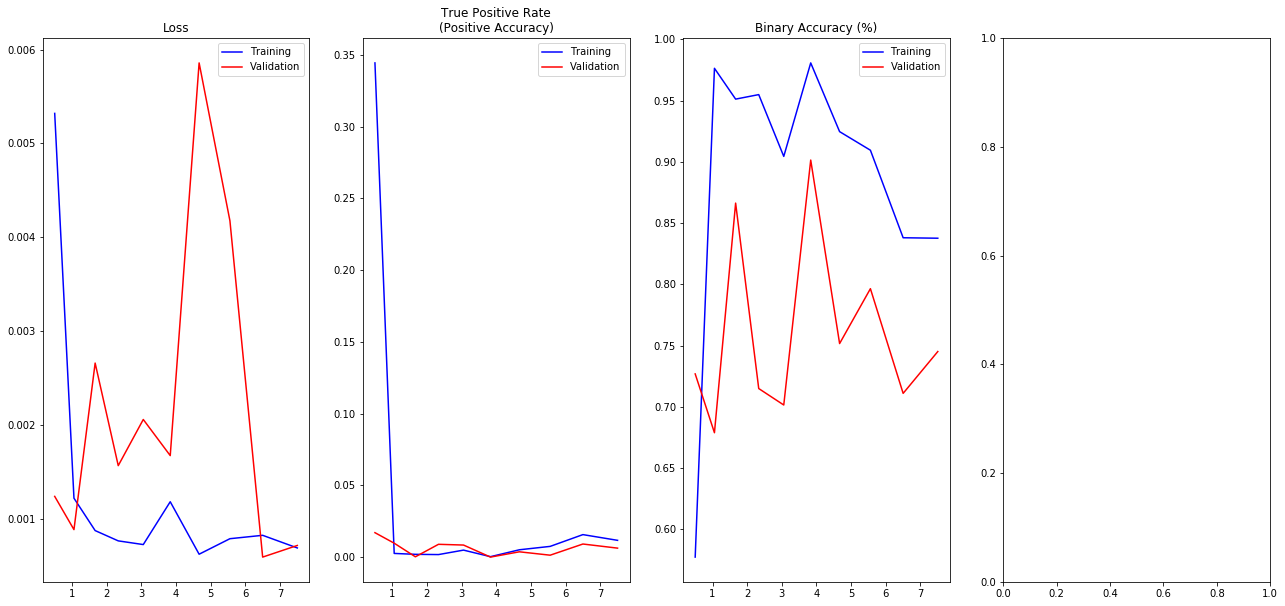

In [22]:
epich = np.cumsum(np.concatenate([np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
_ = ax1.plot(epich,
             np.concatenate([mh.history['loss'] for mh in loss_history]),
             'b-',
             epich, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 
             'r-')
ax1.legend(['Training', 'Validation'])
ax1.set_title('Loss')

_ = ax2.plot(epich, np.concatenate([mh.history['true_positive_rate'] for mh in loss_history]), 
             'b-', epich, 
             np.concatenate([mh.history['val_true_positive_rate'] for mh in loss_history]),
             'r-')
ax2.legend(['Training', 'Validation'])
ax2.set_title('True Positive Rate\n(Positive Accuracy)')

_ = ax3.plot(epich, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]),
             'b-', epich, 
             np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]),
             'r-')
ax3.legend(['Training', 'Validation'])
ax3.set_title('Binary Accuracy (%)')
    
_ = ax4.plot(epich, np.concatenate([mh.history['dic_coef'] for mh in loss_history]), 
             'b-', epich, 
             np.concatenate([mh.history['val_dic_coef'] for mh in loss_history]),
             'r-')
ax4.legend(['Training', 'Validation'])
ax4.set_title('DICE')


In [ ]:
#seg_model.load_weights(weight_path)
#seg_model.save('seg_model.h5')b

# Prediction

In [23]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    if isMultiGPU:
        fullres_model = parallel_model
    else:
        fullres_model = seg_model
#fullres_model.save('fullres_model.h5')

In [24]:
print(len(test_images_list), 'test images found')

15606 test images found


In [ ]:
%%time
from tqdm import tqdm_notebook
from skimage.morphology import binary_opening, disk
out_pred_rows = []
for c_img_name in tqdm_notebook(test_images_list):
    c_path = str(test_path / c_img_name)
    c_img = io.imread(c_path)
    c_img = np.expand_dims(c_img, 0) / 255.0
    cur_seg = fullres_model.predict(c_img)[0]
    cur_seg = binary_opening(cur_seg > 0.5, np.expand_dims(disk(2), -1))
    cur_rles = multi_rle_encode(cur_seg)
    if len(cur_rles) > 0:
        for c_rle in cur_rles:
            out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
    else:
        out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]
    gc.collect()


# Create Submission file

In [ ]:
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
sub_file_name = 'submission_{}.csv'.format(datetime.now().strftime('%Y%m%d%H%M%S'))
submission_df.to_csv(sub_file_name, index=False)
submission_df.head()